# EECS 442 Assignment 5(3): Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Microsoft Research in Cambridge (MSRC) image understanding v2 dataset.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) David FOUHEY, #12345678

**Your Answer:**   
Andrew SCHEFFER #88550453

## Setup
First, we will install some required packages for this notebook and download the MSRC-v2 Image dataset. 


In [1]:
# install required packages and download the dataset
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install colormap easydev pypng torchsummary

In [2]:
import os
import time
import json
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed will be slowed down")
    device = 'cpu'

Using the CPU. Overall speed will be slowed down


## Dataset
We will create a custom Dataset function for the MSRC-v2 dataset. You don't have to change anything here.

In [4]:
N_CLASS = 5

class DeepScoresDataset(Dataset):
    def __init__(self, split, 
                 split_path="ds2_dense/split.json",
                 one_hot=False):
        super().__init__()
        self.one_hot = one_hot
        img_folder = 'ds2_dense/Images'
        mask_folder = 'ds2_dense/GroundTruth'
        GTQ_folder = 'ds2_dense/GT_Quantize'
        
        self.dataset = json.load(open(split_path, 'r'))[split]
        
        self.group2label_idx = {'void': 0, 'lineNote': 1, 'quarterRest': 2, 'clef': 3, 'middleNote': 4}
        
        self.img_list = [data[0] for data in self.dataset] #These are file names
        self.mask_list = [data[1] for data in self.dataset] #These are file names
        GTQ_list = [data[2] for data in self.dataset] #These are file names
        self.imgs = [np.array(Image.open(os.path.join(img_folder, img))) 
                     for img in self.img_list]
        self.masks = [np.array(Image.open(os.path.join(mask_folder, mask))) 
                      for mask in self.mask_list]
        self.q_masks = [np.load(os.path.join(GTQ_folder, gtq))
                        for gtq in GTQ_list]
            
        self.transform = transforms.Compose([
            transforms.Resize((848, 600))
        ])

    @staticmethod
    def rgb2str(rgb): return f"{rgb[0]},{rgb[1]},{rgb[2]}"

    @staticmethod
    def str2rgb(string): return [int(v) for v in string.split(',')]
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img = torch.FloatTensor(self.imgs[idx]).permute(2, 0, 1)
        qmask = torch.LongTensor(self.q_masks[idx])[None, :, :]
        qmask = qmask.squeeze()
        if self.one_hot:
            H, W = qmask.shape
            qmask = torch.nn.functional.one_hot(qmask.reshape(-1), len(self.group2label_idx)).reshape(H, W, -1)
            qmask = qmask.permute(2, 0, 1)
            assert torch.max(qmask) == 1
        
#         # Resize
#         resize = transforms.Resize(size=(img.shape[0]/2, img.shape[1]/2))
#         img = resize(img)
#         qmask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            img, output_size=(256, 512))
        img = transforms.functional.crop(img, i, j, h, w)
        qmask = transforms.functional.crop(qmask, i, j, h, w)
        
        
        return img, qmask

## Model
Design and implement your Convolutional NeuralNetworks to perform semantic segmentation on the MSRC-v2 dataset. 

As mentioned in the course, a normal semantic segmentation model should output a mask with the same size as the input that indicate the pixel-wise classification for the input.

Generally, the basic elements of a convolutional semantic segmentation network include:
1. Convolutional blocks:
    - Typically consists of multiple convolutional layers, activation layers (like ReLU layer), BatchNorm layers, and/or Dropout layers.
2. Down-sampling layers:
    - Can be a simple pooling layer(Max-pooling or Average-Pooling) or convolutional layer with stride not equal to 1
3. Up-sampling layers:
    - Can be a simple up-sampling method like bilinear interpolation or transpose/inversed convolutional layers.
By combining these three types of blocks, you should be able to build your own model to achieve the goal of semantic segmentation.

One example of designing such model inspired by U-Net [1] is:
1. Convolutional block with several Conv-ReLU layers with #channel $3\to C$ (input to output)
2. Down-sampling layer with down-sampling factor $s$ (output shape $(N, C, H/s, W/s)$)
3. Convolutional block with several Conv-ReLU layers with #channel $C\to 2C$
4. Down-sampling layer with down-sampling factor $s$ (output shape $(N, 2C, H/s^2, W/s^2)$)
5. Single convolutional layer with #channel $2C\to 2C$
6. Up-sampling layer with up-sampling factor $s$ (output shape $(N, 2C, H/s, W/s)$)
7. Convolutional block with several Conv-ReLU layers with #channel $2C\to C$
8. Up-sampling layer with up-sampling factor $s$ (output shape $(N, C, H, W)$)
9. Convolutional block with several Conv-ReLU layers with #channel $C\to \text{N_CLASS}$

And the final output will have the same height and width as the input image, which is $(N, \text{N_CLASS}, H, W)$. $\text{N_CLASS}$ indicate the number of classes in the task, you can treat the output to be a classification task on each pixel. This is also why we will use Cross-Entropy loss as the objective function of the model.

Besides the architecture mentioned above, we also encourage you to try other ways to design your own semantic segmentation network with the basic elements mentioned above.

You are also allowed to use tricks like skip connection in your model, but they are not necessary for you to pass this part of the assignment.

[1] O. Ronneberger, P. Fischer, and T. Brox, “U-net:  Convolutional networks for biomedical image seg-mentation,”ArXiv, vol. abs/1505.04597, 2015

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        ########################################################################
        # TODO: Implement a sematic segmentation model                         #
        ########################################################################
        self.sampling_factor = 2
        
        self.relu = nn.ReLU()
        
        #First Block (Downsampling 1)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(self.sampling_factor)
        
        #Second Block (Downsampling 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.maxpool2 = nn.MaxPool2d(self.sampling_factor)
        
        #Center Convolution
        self.convMiddle = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        
        #Third block (Upsampling 1)
        self.upsample1 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1, stride=1)
        
        #Fourth block (upsampling 2)
        self.upsample2 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv7 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.conv8 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        
        self.conv9 = nn.Conv2d(32, self.n_class, 3, padding=1, stride=1)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.convMiddle(x)
        x = self.relu(x)
        
        x = self.upsample1(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        
        x = self.conv9(x)
        
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return x

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [6]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,112,112), device=device)

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
              ReLU-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           9,248
              ReLU-4         [-1, 32, 112, 112]               0
         MaxPool2d-5           [-1, 32, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          18,496
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
              ReLU-9           [-1, 64, 56, 56]               0
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          36,928
             ReLU-12           [-1, 64, 28, 28]               0
         Upsample-13           [-1, 64, 56, 56]               0
           Conv2d-14     

Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

In [7]:
def save_label(label, path, ):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#0080FF',
        '#000000',
        '#80FF80',
        '#FF8000',
        '#AA8000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    cnt = 0
    net = net.train()
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        cnt += 1
    end = time.time()
    running_loss /= cnt
    print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
    return running_loss

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print('\n',losses / cnt)
    return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(N_CLASS)]
        heatmaps = [[] for _ in range(N_CLASS)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(N_CLASS):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(N_CLASS):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))
        print("Average Precision (all classes) = {}".format(np.mean(aps)))
    return None


def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    os.makedirs(folder, exist_ok=True)
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.argmax(output, 0).astype('uint8')
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave('./{}/x{}.png'.format(folder, cnt),
                     images[0].cpu().data.numpy().astype(np.uint8).transpose(1,2,0))
            cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure(figsize=(12, 8))
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('part3_training_hist.png', dpi=300)
    plt.show()

Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.65 all classes AP** on the test set. We also encourage to try to get a higher AP by improving your model design.

On normal Intel core CPU configuration, a valid model design that meets this requirement takes no longer than **10 minutes** to train. The same model take no more than **5 mintues** to finish the code below on Colab. You may use this as a reference when designing your own model. A network that is too deep/too large is not encouraged considering the size of the dataset.

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
%%time
# Set up the random seed for reproducibility, you should not modify the seed used here
torch.manual_seed(442)
random.seed(442)
np.random.seed(442)

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
#criterion = DiceLoss()

# Define the dataset and dataloder
print("HEre")
train_data = DeepScoresDataset("train")
print("HEre")
val_data = DeepScoresDataset("validation")
print("HEre")
test_data = DeepScoresDataset("test")
print("HEre")

##############################################################################
# TODO: Modify the lines below to experiment with different batchsize        #
##############################################################################
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################
test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = DeepScoresDataset("test", one_hot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

##############################################################################
# TODO: Choose a proper optimizer for your model and set up corresponding    #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
learning_rate = 0.001
weight_decay = 0#1e-5
num_epoch = 10  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

print('\nStart training')
trn_hist = []
val_hist = []
net.train()
for epoch in range(num_epoch): #TODO: Change the number of epochs
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
    print('Validation loss: ')
    val_loss = test(val_loader, net, criterion, device)
    trn_hist.append(trn_loss)
    val_hist.append(val_loss)

net.eval()
plot_hist(trn_hist, val_hist)
##########################################################################
# TODO: Submit the "Average Precision(all classes)" value in the report  #
##########################################################################
print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')
##############################################################################
# You can visualize your segmentation results using get_results function     #
# Your result will be dumped in the folder 'output_test'.                    #
# There will be three files for each image:                                  # 
#   (1) gt<num>.png (ground truth label)                                     #
#   (2) x<num>.png (input RGB image)                                         #
#   (3) y<num>.png (predicted output)                                        #
#                                                                            #
# TODO: Find a satisfactory result by running the next cell and report       #
#       the plot of gt<num>.png, x<num>.png and y<num>.png in the pdf        #
# Note: Your submission doesn't have to be perfect.                          #
##############################################################################
result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_skiplink_{}.pth'.format(name))
print("Here")
cal_AP(ap_loader, net, criterion, device)

HEre
HEre
HEre
HEre


  0%|          | 0/25 [00:00<?, ?it/s]


Start training
-----------------Epoch = 1-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 [epoch 1] loss: 0.222 elapsed time 44.180
Validation loss: 


  0%|          | 0/25 [00:00<?, ?it/s]


 0.028695897292345764
-----------------Epoch = 2-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 [epoch 2] loss: 0.040 elapsed time 43.641
Validation loss: 


  0%|          | 0/25 [00:00<?, ?it/s]


 0.03512777588330209
-----------------Epoch = 3-----------------


  0%|          | 0/10 [00:00<?, ?it/s]


 [epoch 3] loss: 0.033 elapsed time 45.513
Validation loss: 


  0%|          | 0/25 [00:00<?, ?it/s]


 0.018357111758086832
-----------------Epoch = 4-----------------


  4%|▍         | 1/25 [00:01<00:43,  1.81s/it]

image: 3


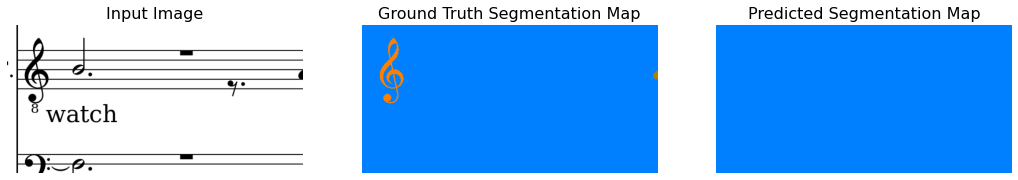

In [10]:
img_idx = 3

print(f'image: {img_idx}')
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()